# Produce potential approximations

This notebook produces approximations of a 1D potential, by default the smoothed Coulomb potential, in terms of
linear combinations of gaussians. The approximation is stored to a pickle file.

There are some leftovers in this notebook from experiments with optimizing a complex tempered sequence, as opposed to a real-valued one, which turned out to work best after all.

The strategy is as follows:
1. Choose half the number $n$ of gaussians.
2. Produce an initial approximation in terms of a tempered sequence of length $n$ of gaussians. This approximation is produced by optimizing the generating coefficients. The basis resulting is explicitly real, and symmetric upon reflextion about $x=0$.
3. The optimization is using a weighted $L^\infty$ norm, placing more importance on the error near the origin, than far away. Since RSPT error estimates are in the $L^\infty$ norm, and since the ground state is localized near the origin, this should produce a potential with a very accurate ground state energy and wavefunction.
4. The tempered sequence is subsequently optimized to produce an even better approximation, letting the width coefficients be unconstrained.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gauss1d import Gauss1D, LCGauss1D, plot_basis
from icecream import ic

# Hack the dark theme for the widget, so that the background is black.
%matplotlib widget
plt.style.use('dark_background')
from vscode_dark_ipywidget_fix.inject_css import inject_css
inject_css()
g = Gauss1D()

In [138]:
# Grid
a = -200
b = 200
ng = 8001
x = np.linspace(a, b, ng)

n = 15
p = np.inf

# Define external potential
V_fun = lambda x: -1.0/(x**2 + 2)**.5
V = V_fun(x)

weight = lambda x: np.exp(-.05*np.abs(x))

name = 'smoothed_coulomb'


In [139]:

df = LCGauss1D(g)

def promote_tempered(z0):
    z = np.zeros((4,n))
    w = np.linspace(z0[0], z0[1],  n)
    z[0,:] = w
    
    return z

def promote_generalized_tempered(z0):
    z = np.zeros((4,n*2))
    w = (z0[0] + 1j*z0[1]) ** np.arange(1, n+1)
    z[0,:n] = np.log(np.abs(np.real(w)))
    z[1,:n] = np.imag(w)
    z[0,n:] = z[0,:n]
    z[1,n:] = -z[1,:n]
    
    return z

def promote_ab(z0):
    z = np.zeros((4,n*2))
    z0 = z0.reshape((2,n))
    z[0,:n] = z0[0,:]
    z[1,:n] = z0[1,:]
    z[0,n:] = z0[0,:]
    z[1,n:] = -z0[1,:]
    
    return z

def promote_a(z0):
    z = np.zeros((4,n))
    z0 = z0.reshape((1,n))
    z[0,:] = z0[0,:]
    
    return z


def objective(z_vec, promote, verbose=False, print_every=100, p=2, purify=False):
    z = promote(z_vec)
    df.set_z(z)
    #df.overlap_matrix()
    c = df.projection(x, V)
    if purify: # only relefant for generalized_tempered type basis
        c_block = (c[:n] + c[n:].conj())/2 # purify c
        c = np.concatenate([c_block, c_block.conj()])
    
    
    PV = df.eval_grid(x, c)

    if p < np.inf:
        cost = np.sum(weight(x) * np.abs(V - PV)**p * (x[1]-x[0]) )**(1/p) 
    else:
        cost = np.max(weight(x) * np.abs(V - PV))
        
    objective.n_eval += 1
    if verbose:
        if objective.n_eval % print_every == 0:
            print(f'{objective.n_eval} {cost}')
    return cost

objective.n_eval = 0


# def test_objective(z_vec, promote, verbose=False, print_every=100, p=2):
#     z = promote(z_vec)
#     df.set_z(z)
#     df.overlap_matrix()
#     c = df.projection(x, V)
#     S = df.S
    
#     # print matrix df.S with 2 decimals
#     # ic(df.S)
#     test = np.linalg.norm(c[:n]-c[n:].conj())
#     #test2 = np.linalg.norm(S[:n,:n] - S[n:,n:].conj()) + np.linalg.norm(S[:n,n:] - S[n:,:n].conj())
#     # print('c is not symmetric')
#     # print('c block structure error:', test)
#     # print('S block structure error: ', test2)
#     # print('cond S = ', np.linalg.cond(S))
#     #print(np.array2string(np.round(df.S,2)))
#     #print(np.array2string(np.round(c,2)))

#     return test, np.linalg.cond(S)

# c_err = []
# S_cond = []
# for k in range(1000):
#     y = np.random.randn(2)
#     #promote_generalized_tempered(y)
#     promote_tempered(y)
#     c_err0, S_cond0 = test_objective(y, promote_generalized_tempered, verbose=True, print_every=100, p=p)
#     #c_err0, S_cond0 = test_objective(y, promote_tempered, verbose=True, print_every=100, p=2)
#     c_err.append(c_err0)
#     S_cond.append(S_cond0)
    
# plt.figure()
# plt.scatter(c_err, S_cond)
# plt.xlabel('c error')
# plt.ylabel('S condition number')
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


In [140]:
from scipy.optimize import minimize

def optimize_several_times(n_times, promote, n_var, p=2, purify=False):

    np.random.seed(10)

    cost_best = np.inf
    y_best = None
    y_list = []
    for k in range(n_times):
        y = np.array([-6,6]) + 10*np.random.randn(n_var)
        objective.n_eval = 0
        fun = lambda z: objective(z, promote, p=p, purify=purify)
        res = minimize(fun, y, method='Powell', options={'maxiter': 1000}, tol=1e-7)
        #print(res)
        #print(df.z)
        ic(res.fun, res.x)
        if res.fun < cost_best:
            ic('New best!')
            cost_best = res.fun
            y_best = res.x
        y_list.append(res.x)

    return y_best, y_list

#y_best, y_list = optimize_several_times(40, promote_generalized_tempered, 2, p=p, purify=True)
y_best, y_list = optimize_several_times(20, promote_tempered, 2, p=p)

ic| res.fun: 0.07709863380939276
    res.x: array([-118.77522746,    7.07903252])
ic| 'New best!'
ic| res.fun: 0.00015137173559122207
    res.x: array([-10.94334294,   5.81465865])
ic| 'New best!'
ic| res.fun: 0.003978489973793455
    res.x: array([-4.00829938, -1.20085503])
ic| res.fun: 0.0001518495041184296
    res.x: array([-10.90860511,   5.76740072])
ic| res.fun: 2.058839096719583e-05
    res.x: array([-9.27738352,  3.93695725])
ic| 'New best!'
ic| res.fun: array(nan), res.x: array([nan, nan])
ic| res.fun: 0.08280301797922766
    res.x: array([-320.01483066,   -2.00380302])
ic| res.fun: 4.7779193451701934e-05
    res.x: array([-8.91997564,  1.11231102])
ic| res.fun: 1.7603233555265843e-05
    res.x: array([-9.2711233 ,  3.84646882])
ic| 'New best!'
ic| res.fun: 0.0019863391745583315
    res.x: array([-0.53340521, -4.79823277])
ic| res.fun: 3.0820952866146046e-05
    res.x: array([  2.03006449, -11.43376124])
ic| res.fun: 0.08280378456914017
    res.x: array([-324.03604546,   -2.00

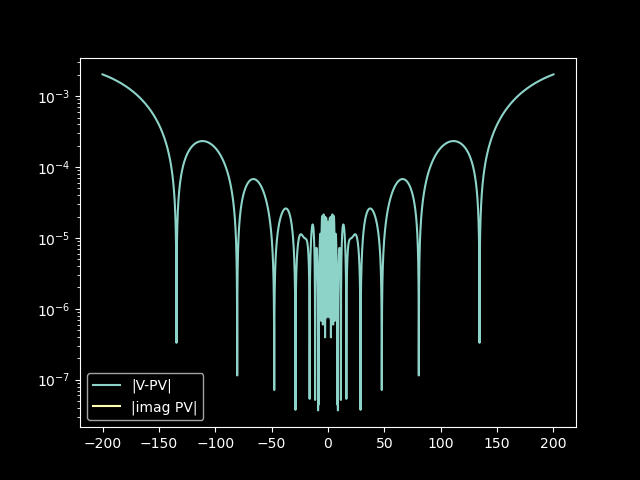

(<Figure size 640x480 with 1 Axes>, <Axes: >)

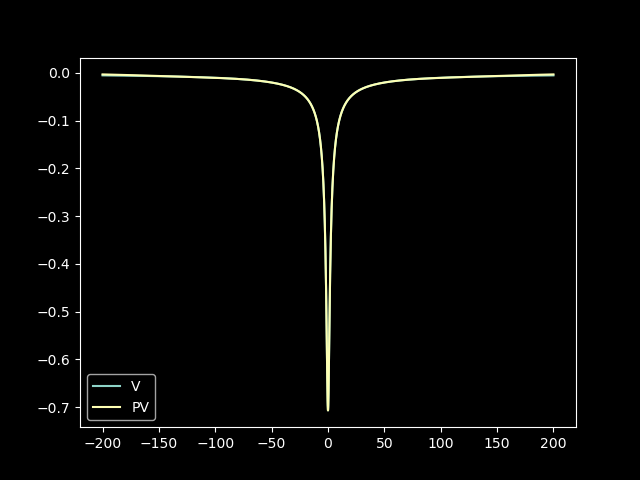

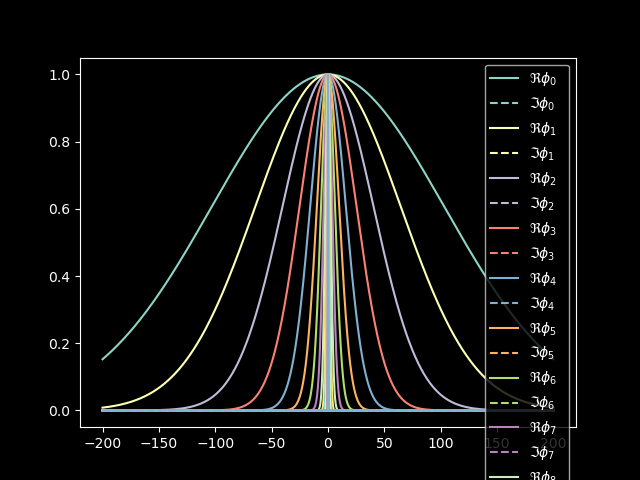

In [141]:
def plot_potential_approx(z_pot, purify=False):
    df.set_z(z_pot)
    c = df.projection(x, V)
    if purify:
        c_block = (c[:n] + c[n:].conj())/2 # purify c
        c = np.concatenate([c_block, c_block.conj()])
    PV = df.eval_grid(x, c)
    plt.figure()
    plt.plot(x, V, label='V')   
    plt.plot(x, PV, label='PV')
    plt.legend()
    plt.figure()
    plt.semilogy(x, np.abs(V - PV), label='|V-PV|')
    plt.semilogy(x, np.abs(PV.imag), label='|imag PV|')
    plt.legend()
    plt.show()

plot_potential_approx(promote_tempered(y_best))
#plot_potential_approx(promote_generalized_tempered(y_best))

plot_basis(df.z, x, g)



In [142]:

objective.n_eval = 0
fun = lambda z: objective(z, promote_a)
z_best = promote_tempered(y_best)
#z_best = promote_generalized_tempered(y_best)
y = z_best[:1,:n].flatten()

In [143]:
objective.n_eval = 0
fun = lambda y: objective(y, promote_a, verbose=True, print_every=100, p=p)
res = minimize(fun, y, method='Powell', options={'maxiter': 1000}, tol=1e-7)
y_best2 = res.x
print(res.x, res.fun)


100 8.046028681210662e-05
200 2.327703616447402e-05
300 2.0811303978842726e-05
400 1.7595277875759193e-05
500 1.7595284908828873e-05
600 1.759527743394011e-05
700 8.058251379496173e-05
800 1.7753464937911858e-05
900 2.0774952232207146e-05
1000 1.758366224835978e-05
1100 0.00010089391563284543
1200 1.7574372069149556e-05
1300 1.7574372448730357e-05
1400 1.7572419092830562e-05
1500 1.7572418531630476e-05
1600 1.7572418532546406e-05
1700 0.00041709643298610963
1800 1.8201935546340952e-05
1900 1.7574921049039783e-05
2000 1.767942656476368e-05
2100 1.757245621156136e-05
2200 1.7572382427180717e-05
2300 1.7572183637640146e-05
2400 1.7572146788040362e-05
2500 1.7572146685502067e-05
2600 1.7572146545602564e-05
2700 1.7572131580598516e-05
2800 1.7572128130011823e-05
2900 1.7572128129146135e-05
3000 1.7572128128736096e-05
3100 1.891367486586368e-05
3200 1.7618927845009926e-05
3300 1.8332216334558645e-05
3400 0.0001308828350668795
3500 1.784320015061047e-05
3600 1.760227427260085e-05
3700 1.75745

In [144]:
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.75721253833023e-05
       x: [-9.270e+00 -8.334e+00 ...  2.909e+00  3.846e+00]
     nit: 7
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 4705

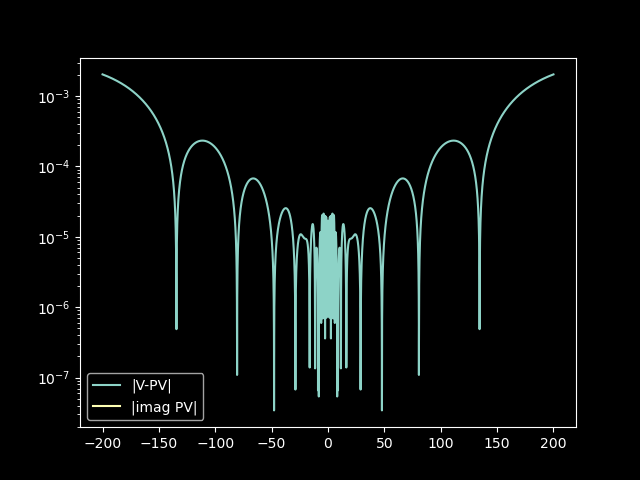

(<Figure size 640x480 with 1 Axes>, <Axes: >)

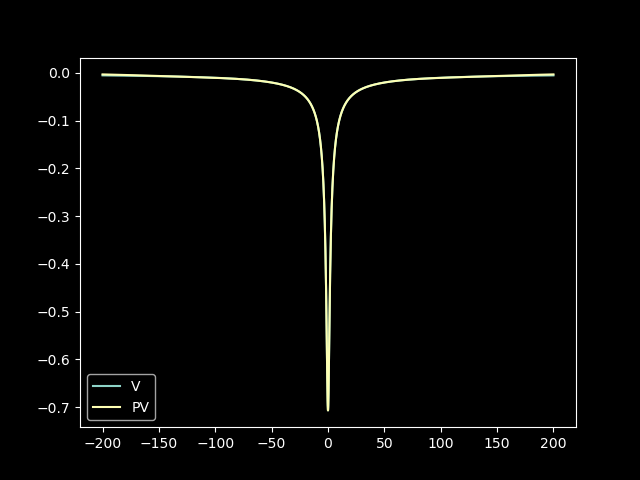

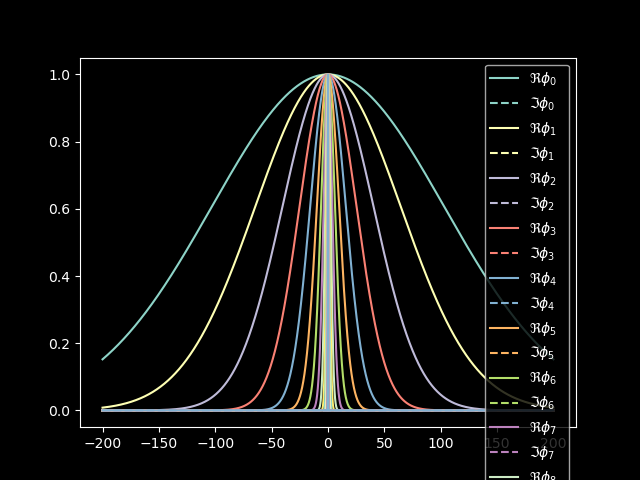

In [145]:
plot_potential_approx(promote_a(res.x))
# c = df.projection(x, V)
# PV = df.eval_grid(x, c)
# plt.figure()
# plt.plot(x, V, label='V')   
# plt.plot(x, PV, label='PV')
# plt.legend()
# plt.figure()
# plt.semilogy(x, np.abs(V - PV), label='|V-PV|')
# plt.semilogy(x, np.abs(PV.imag), label='|imag PV|')
# plt.legend()
# plt.show()

plot_basis(df.z, x, g)

In [146]:
z_pot = promote_a(res.x)
df.set_z(z_pot)
c_pot = df.projection(x, V)
#c_pot = (c_pot[:n] + c_pot[n:].conj())/2 # purify c
#c_pot = np.concatenate([c_pot, c_pot.conj()])
df.set_potential(c_pot, z_pot)
z_diag = np.zeros((4,25))
z_diag[0,:] = np.linspace(-7, 7, 25)
df.set_z(z_diag)
df.set_regularization(lambda_P=1e-3, type_P='tikhonov')
df.overlap_matrix()


In [148]:
from scipy.linalg import eigh
df.hamiltonian_matrix()
S, H = df.S, df.H
e, v = eigh(H, S)
print(e)
print(e[0])

[-4.99999999e-01 -1.33828908e-01 -5.88591785e-02 -3.27378927e-02
 -2.07915097e-02 -1.43086370e-02 -9.91410661e-03  3.92738122e-03
  4.73991111e-02  1.50907663e-01  3.69267227e-01  8.00047490e-01
  1.61651301e+00  3.12815735e+00  5.88904186e+00  1.08916851e+01
  1.99156725e+01  3.61594402e+01  6.53940200e+01  1.18099932e+02
  2.13530592e+02  3.87824042e+02  7.11715098e+02  1.33637838e+03
  2.66348883e+03]
-0.4999999993135334


In [149]:
lcg_state = {'c': c_pot, 'z': z_pot, 'name': name, 'E0': e[0]}

# save
import pickle
with open(f'lcg_{lcg_state["name"]}_ngauss_{len(c_pot)}_p_{p}.pkl', 'wb') as f:
    pickle.dump(lcg_state, f)

